In [1]:

# Regular modules for data science and visualization:

import numpy as np

import pandas

import seaborn as sns

import matplotlib.pyplot as plt






import tensorflow as tf

import tensorflow_hub as hub





from keras.regularizers import l1, l2

from keras.models import Sequential

from keras.layers import Dense

from keras.layers import Dropout

from keras import backend

from keras import optimizers



#sklearn and imblearn modules:

from sklearn.model_selection import cross_val_predict

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import StratifiedShuffleSplit

from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [2]:
import pandas as pd
import random
p = 0.4

df = pd.read_csv('articles2.csv',header=None,skiprows=lambda i: 1>0 and random.random() > p)



n_s_a = df[df[3] == 'Atlantic']

n_s_p = df[df[3] == 'New York Post']



df = pd.read_csv('articles1.csv',header=None,skiprows=lambda i: 1>0 and random.random() > p)

n_s_b = df[df[3] == 'Breitbart']

n_s_n = df[df[3] == 'New York Times']

In [3]:
n_s = list(n_s_b.iloc[:,9].values) + list(n_s_p.iloc[:,9].values) \
 + list(n_s_a.iloc[:,9].values) + list(n_s_n.iloc[:,9].values)

In [4]:
n_s = [word.replace('New York Post','') for word in n_s]
n_s = [word.replace('Breitbart','') for word in n_s]
n_s = [word.replace('New York Times','') for word in n_s]
n_s = [word.replace('Atlantic','') for word in n_s]

In [5]:



classes_All = np.asarray([1 for i in range(len(n_s_b))] + \

[2 for i in range(len(n_s_p))] + [3 for i in range(len(n_s_a))] + \

[4 for i in range(len(n_s_n))])


classes_Bias = np.asarray([1 for i in range(len(n_s_b))] + \

[1 for i in range(len(n_s_p))] + [2 for i in range(len(n_s_a))] + \

[2 for i in range(len(n_s_n))])

In [6]:
:

g = tf.Graph()

with g.as_default():

  text_input = tf.placeholder(dtype=tf.string, shape=[None])

  embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-large/3")

  embedded_text = embed(text_input)

  init_op = tf.group([tf.global_variables_initializer(), tf.tables_initializer()])

g.finalize()





session = tf.Session(graph=g)

session.run(init_op)




def similarity_matrix(merge_list):

  

    emb_all = np.zeros([len(merge_list),512])


    for i in range(0,len(merge_list)):

        

        i_emb = session.run(embedded_text, feed_dict={text_input: [merge_list[i]]})

        emb_all[i,:] = i_emb

    return emb_all

In [7]:
e_All = similarity_matrix(n_s)

In [8]:



optim = optimizers.Adam(lr=0.00015) 





news_DNN = Sequential()

news_DNN.add(Dense(40, input_dim=512, activation = 'relu',kernel_regularizer=l2(0.1)))

news_DNN.add(Dropout(0.25))

news_DNN.add(Dense(40, activation = 'relu',kernel_regularizer=l2(0.1)))

news_DNN.add(Dropout(0.25))







news_DNN.add(Dense(2,activation='softmax'))




news_DNN.compile(loss='sparse_categorical_crossentropy', optimizer=optim, metrics=['acc'])

W0117 13:08:58.517569  6956 deprecation_wrapper.py:119] From C:\Users\HeavyD\Anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0117 13:08:58.517569  6956 deprecation_wrapper.py:119] From C:\Users\HeavyD\Anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0117 13:08:58.572875  6956 deprecation_wrapper.py:119] From C:\Users\HeavyD\Anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0117 13:08:58.623783  6956 deprecation_wrapper.py:119] From C:\Users\HeavyD\Anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0117 13:08:58.632544  6956 deprecation.py:506

In [9]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.33)
scaler=StandardScaler()
for t, te in sss.split(e_All,classes_Bias):



    x_train,x_test = scaler.fit_transform(e_All)[t],scaler.fit_transform(e_All)[te]

   



    y_train, y_test = classes_Bias[t]-1,classes_Bias[te]-1

In [10]:
[x_train_r, y_train_r] = SMOTE().fit_resample(x_train, y_train)
m_h = news_DNN.fit(x_train_r, y_train_r, epochs=400, \

validation_data=(x_test, y_test), batch_size=32, verbose=0)

W0117 13:09:30.633824  6956 deprecation.py:323] From C:\Users\HeavyD\Anaconda\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [19]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix 
acs(y_test,news_DNN.predict_classes(x_test))

0.8398262522057826

In [18]:
news_DNN.save('news.h5')

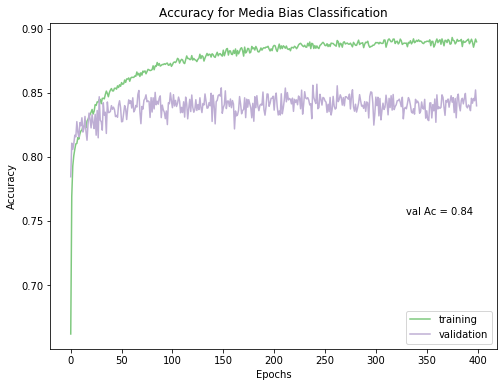

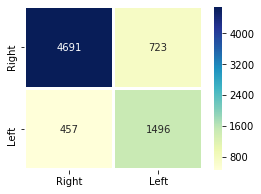

In [22]:

with sns.color_palette("Accent", n_colors=8):

    plt.figure(figsize=(8,6))

    sns.lineplot(data=np.asarray(m_h.history['acc']))

    sns.lineplot(data=np.asarray(m_h.history['val_acc']))

    plt.xlabel("Epochs")

    plt.ylabel("Accuracy")

    plt.title("Accuracy for Media Bias Classification") 

    plt.legend(labels=['training', 'validation'],loc='lower right')

    plt.text(330,0.755,'val Ac = ' + str(round(accuracy_score(y_test,news_DNN.predict_classes(x_test)),2))) 

    plt.savefig('outlets_bias_acc.svg',format='svg')





plt.figure(figsize=(4, 3))

sns.heatmap(confusion_matrix(y_test,news_DNN.predict_classes(x_test)),annot=True,linewidths=2, cmap="YlGnBu",fmt="g",xticklabels=['Right','Left'],yticklabels=['Right','Left'])

plt.autoscale()

plt.savefig('confusion_matrix_outlet_bias_bal.png',format='PNG',bbox_inches = "tight")